# Feature Engineering

This file is part of my work on Udacity's Nano Degree Programme.

As capstone project I compare the performance of a machine learning model in predicting matches of the 2020 UEFA European Football Championship with my personal bets in a football guessing game played on the platform www.kicktipp.de

In this notebook we perform some feature engineering. Based on the data raised using web crawling we compute the rolling averages of different statistics of games played by the teams in the past. Moreover, we perform some data exploration and visualize the correlations between features and the number of goals scored.

Two output files:
   - File containing the rolling averages for the last game played. They serve as input for predicting the results at UEFA Euro 2020.
   - File containing the rolling averages for each match in our training set. This file serves as training set for the model building

In [1]:
import os

In [2]:
import numpy as np
import pandas as pd

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
import re

## Input Parameter

In [5]:
file_matches_training = 'matches_training_ml.xlsx '

output_features_last_match = '20220323_features_last_match.xlsx'
output_features_matches_training = '20220323_features_matches_training.xlsx'

path_input = '../data/'
path_output = '../data/'

## Data Wrangling for Feature Engineering

In [6]:
def read_and_prepare_matches_for_training():
    '''
    INPUT:  -
    OUTPUT: Returns the 'training'-data generated in the crawling step as a dataframe. Minor preprocessing steps,
            like renaming of columns, changing the type of some columns or a renaming of a country are done.
    '''
    df = pd.read_excel(os.path.join(path_input, file_matches_training))
    
    df = df.drop(columns = ['url'])
        
    # Transformation of the date column from string to date
    df['date'] = pd.to_datetime(df['date'])
    df['date'] = df['date'].apply(lambda x: x.replace(tzinfo=None))

    # We have to remove the '%' character from the possession-features and transform them into an integer
    cols_to_transform = ['possession_home', 'possession_away']

    for col in cols_to_transform:
        df[col] = df[col].apply(lambda possession_string : possession_string[:-1]).astype(int)
        
    # There is a country that was renamed. Its former name is FYR Macedonia and now its official name is North Macedonia.
    cols_teams = ['team_home', 'team_away']
    
    for col in cols_teams:
        df[col] = df[col].apply(lambda team : team if team != 'FYR Macedonia' else 'North Macedonia')
        
    return df

In [7]:
df_matches_training = read_and_prepare_matches_for_training()

In [8]:
df_matches_training.head(5)

,team_home,team_away,date,goals_home,goals_away,attempts_total_home,attempts_total_away,attempts_off_target_home,attempts_off_target_away,attempts_on_target_home,...,balls_recovered_home,balls_recovered_away,tackles_home,tackles_away,blocks_home,blocks_away,clearances_home,clearances_away,passes_accuracy_home,passes_accuracy_away
0,Italy,Bosnia and Herzegovina,2020-09-04 18:45:00,1,1,19,9,11,4,4,...,33,33,2,1,1,4,0,0,87,78
1,Netherlands,Poland,2020-09-04 18:45:00,1,0,15,2,6,1,4,...,30,33,3,4,0,5,0,0,87,77
2,Bosnia and Herzegovina,Poland,2020-09-07 18:45:00,1,2,7,14,4,7,2,...,28,25,3,6,2,1,0,0,79,86
3,Netherlands,Italy,2020-09-07 18:45:00,0,1,11,17,4,10,3,...,36,44,7,4,3,4,0,0,80,89
4,Bosnia and Herzegovina,Netherlands,2020-10-11 16:00:00,0,0,6,14,2,8,1,...,38,42,3,2,2,3,0,0,78,88


In [9]:
def extract_features_home_away_team(df, home_away):
    '''
    INPUT:  Dataframe df containing the data of all matches and a binary variable home_away, 
            which equals either '_home' or '_away'.
    OUTPUT: df restricted to the columns ending with 'home_away' and the date column. 
            Moreover, the suffix '_home' or '_away' is removed from the column names.
    '''
    
    # Restriction of the dataframe to a subset of the columns
    cols_subset = ['date'] + [col for col in df.columns if col.endswith(home_away)]
    
    df = df[cols_subset]
    
    # Removal of the suffix '_home' or '_away'
    df.columns = [col.replace(home_away, '') for col in df.columns]
    
    return df

In [10]:
def get_df_information_single_teams(df):
    '''
    INPUT:  Dataframe df containing the data of all matches.
    OUTPUT: Dataframe which contains for each match in df two rows containing the data for home- and away-team seperately.
    '''
    
    dfs_home_away = [extract_features_home_away_team(df.copy(), home_away) for home_away in ['_away', '_home']]
    
    df_info_single_teams = pd.concat(dfs_home_away).reset_index(drop = True)
    
    return df_info_single_teams

In [11]:
df_info_single_teams = get_df_information_single_teams(df_matches_training)

In [12]:
df_info_single_teams.head(5)

,date,team,goals,attempts_total,attempts_off_target,attempts_on_target,attempts_blocked,corners,offsides,possession,passes,passes_completed,balls_recovered,tackles,blocks,clearances,passes_accuracy
0,2020-09-04 18:45:00,Bosnia and Herzegovina,1,9,4,4,1,2,0,41,411,321,33,1,4,0,78
1,2020-09-04 18:45:00,Poland,0,2,1,1,0,4,4,35,346,265,33,4,5,0,77
2,2020-09-07 18:45:00,Poland,2,14,7,5,2,5,1,55,474,409,25,6,1,0,86
3,2020-09-07 18:45:00,Italy,1,17,10,4,3,5,4,57,595,528,44,4,4,0,89
4,2020-10-11 16:00:00,Netherlands,0,14,8,4,2,7,2,68,734,646,42,2,3,0,88


## Feature Engineering

In [13]:
def weighted_mean(c, arr):
    '''
    INPUT:  An array arr of numbers, and a weight c.
    OUTPUT: A weighted mean with exponentially decreasing weights ignoring the last entry of arr.
    '''
    n = len(arr)
    
    weights = [2**(-c*m) for m in range(0, n)][::-1]
    
    return np.dot(weights[1:], arr[:-1])/sum(weights)

In [14]:
def normal_mean(arr):
    '''
    INPUT:  An array arr of numbers.
    OUTPUT: The mean of the numbers in arr ignoring the last entry of arr..
    '''
    n = len(arr)
    
    return sum(arr[:-1])/(n-1)

In [15]:
def perform_feat_engineering_for_country(df_info_single_teams, country):
    '''
    INPUT:  Dataframe, which contains the features of the teams in the matches.
    OUTPUT: A dataframe, which contains (apart from the date, team, and goals) the aggregated features in the last 5 (resp. 10)
            games with respect to the normal mean and an exponentially decreasing mean.
    
    REMARK: For the first games it is impossible to compute the normal/weighted mean for the features because the previous
            games are missing. Therefore, we duplicate the first game several times and compute the average w.r.t. to this
            (repeated) first game.
    '''
    
    df = df_info_single_teams
    
    # Restriction of dataframe to a single country and sorting according to date s.t. we can compute the rolling averages
    df = df[df['team'] == country].sort_values(by = ['date'], ascending = [1]).reset_index(drop = True)
    
    # Duplication of the first games
    df_first_match_duplicated = pd.concat([df.iloc[:1] for i in range(9)])

    df_feat_engi = pd.concat([df_first_match_duplicated, df]).reset_index(drop = True)
    
    col_feat = [col for col in df_feat_engi.columns if col not in ['team', 'date']]
    
    # Compute (weighted) average for each feature on the previous games
    for col in col_feat:
        # Compute weighted mean for feature for last 5 and last 10 games
        df_feat_engi[col + '_weighted_mean_5']  = df_feat_engi[col].rolling(5+1).apply(lambda arr : weighted_mean(0.25, arr))
        df_feat_engi[col + '_weighted_mean_10'] = df_feat_engi[col].rolling(10+1).apply(lambda arr : weighted_mean(0.25, arr))
        
        # Compute normal mean for feature for last 5 and last 10 games
        df_feat_engi[col + '_normal_mean_5']  = df_feat_engi[col].rolling(5+1).apply(lambda arr : normal_mean(arr))
        df_feat_engi[col + '_normal_mean_10'] = df_feat_engi[col].rolling(10+1).apply(lambda arr : normal_mean(arr))
    
    # Drop the rows with the duplicated first game
    df_feat_engi = df_feat_engi[10:].reset_index(drop = True)
    
    return df_feat_engi

In [16]:
def aggregate_data_for_all_countries(df_info_single_teams):
    '''
    INPUT:  Dataframe, which contains the features of the teams in the matches.
    OUTPUT: A dataframe that contains the rolling (weighted) averages of the previous games for each country and match
    '''
    
    countries_all = df_info_single_teams['team'].unique()
    
    dfs_feat_engi_country = [perform_feat_engineering_for_country(df_info_single_teams, country) for country in countries_all]
    
    df_feat_engi = pd.concat(dfs_feat_engi_country)
    
    # Drop the statistics w.r.t. to the match actually played
    cols_to_drop = ['attempts_blocked', 'attempts_off_target', 'attempts_on_target',
                    'attempts_total', 'balls_recovered', 'blocks', 'clearances', 'corners',
                    'offsides', 'passes_accuracy', 'passes_completed', 'passes', 'possession', 'tackles']
    
    df_feat_engi = df_feat_engi.drop(columns = cols_to_drop).dropna().reset_index(drop = True)
    
    return df_feat_engi

In [17]:
df_feat_engi = aggregate_data_for_all_countries(df_info_single_teams)

In [18]:
df_feat_engi.head(5)

,date,team,goals,goals_weighted_mean_5,goals_weighted_mean_10,goals_normal_mean_5,goals_normal_mean_10,attempts_total_weighted_mean_5,attempts_total_weighted_mean_10,attempts_total_normal_mean_5,...,blocks_normal_mean_5,blocks_normal_mean_10,clearances_weighted_mean_5,clearances_weighted_mean_10,clearances_normal_mean_5,clearances_normal_mean_10,passes_accuracy_weighted_mean_5,passes_accuracy_weighted_mean_10,passes_accuracy_normal_mean_5,passes_accuracy_normal_mean_10
0,2018-09-11 18:45:00,Bosnia and Herzegovina,1,1.793038,1.933927,2.0,2.0,4.482596,4.834816,5.0,...,10.0,10.0,0.0,0.0,0.0,0.0,64.549382,69.621354,72.0,72.0
1,2018-10-15 18:45:00,Bosnia and Herzegovina,2,1.546918,1.747042,1.8,1.9,4.728716,5.021700,5.2,...,9.0,9.5,0.0,0.0,0.0,0.0,66.272223,70.929543,73.4,72.7
2,2018-11-15 19:45:00,Bosnia and Herzegovina,0,1.586077,1.776776,1.8,1.9,7.889120,7.421459,7.8,...,7.8,8.9,0.0,0.0,0.0,0.0,68.459315,72.590246,75.4,73.7
3,2019-03-23 19:45:00,Bosnia and Herzegovina,2,1.126765,1.428011,1.4,1.7,9.808332,8.878756,9.8,...,6.4,8.2,0.0,0.0,0.0,0.0,68.083351,72.304769,75.6,73.8
4,2019-03-26 19:45:00,Bosnia and Herzegovina,2,1.232771,1.508504,1.4,1.7,12.406672,10.851727,12.6,...,4.4,7.2,0.0,0.0,0.0,0.0,71.459008,74.867973,78.8,75.4


## Preparing DataFrames for Model Training and Prediction

### DataFrame with Performance of each Team just before EM2020

In [19]:
# Take only the engineered feature for the last match of each team
# These serve as input for the model to predict the games of UEFA Euro 2020
df_features_last_match = df_feat_engi.groupby(['team']).tail(1).reset_index(drop = True).drop(columns = ['date', 'goals'])

### DataFrame with Performance of each Team before each Match for: Basis for Model Training

In [20]:
def prepare_df_for_model_training(df_matches_training, df_feat_engi):
    '''
    INPUT:  Two dataframes:
                - The dataframe containing the matches, we use for training the model.
                - The dataframe containing the engineered features (i.e., the rolling (weighted) averages for the features)
    OUTPUT: A dataframe containing matches with engineered features for both teams.
    
    REMARK: Usually, the team playing at home has an advantage. Since UEFA Euro 2020 takes place on neutral ground (at least
            for most of the pairings) every match is duplicated with each team being one time home team and one time away team.
            This way I hope to remove the home advantage effect. Moreover, after this transformation it does not make sense
            to speak of home and away teams anymore. Therefore, we call these teams team_A and team_B.
    '''
    df_1 = df_matches_training[['date', 'team_home', 'team_away']].copy().rename(columns = {'team_home' : 'team_A',
                                                                                            'team_away' : 'team_B'
                                                                                           })
    
    df_2 = df_matches_training[['date', 'team_home', 'team_away']].copy().rename(columns = {'team_home' : 'team_B',
                                                                                            'team_away' : 'team_A'
                                                                                           })
    
    df_3 = pd.concat([df_1, df_2]).reset_index(drop = True)
    
    cols_a = [col + '_A' if col not in ['date'] else col for col in df_feat_engi.columns]
    cols_b = [col + '_B' if col not in ['date'] else col for col in df_feat_engi.columns]
    
    df_A = df_feat_engi.copy()
    df_A.columns = cols_a
    
    df_B = df_feat_engi.copy()
    df_B.columns = cols_b
    
    df_merge = pd.merge(df_3, df_A, how = 'inner', on = ['date', 'team_A'])
    df_merge = pd.merge(df_merge, df_B, how = 'inner', on = ['date', 'team_B'])
    
    return df_merge

In [21]:
df_matches_training_feat_engi = prepare_df_for_model_training(df_matches_training, df_feat_engi)

In [22]:
df_matches_training_feat_engi.head(5)

,date,team_A,team_B,goals_A,goals_weighted_mean_5_A,goals_weighted_mean_10_A,goals_normal_mean_5_A,goals_normal_mean_10_A,attempts_total_weighted_mean_5_A,attempts_total_weighted_mean_10_A,...,blocks_normal_mean_5_B,blocks_normal_mean_10_B,clearances_weighted_mean_5_B,clearances_weighted_mean_10_B,clearances_normal_mean_5_B,clearances_normal_mean_10_B,passes_accuracy_weighted_mean_5_B,passes_accuracy_weighted_mean_10_B,passes_accuracy_normal_mean_5_B,passes_accuracy_normal_mean_10_B
0,2020-09-04 18:45:00,Italy,Bosnia and Herzegovina,1,4.244941,4.116726,4.2,3.7,18.396572,19.617894,...,3.4,2.7,0.0,0.000000,0.0,0.0,78.923203,84.556986,87.6,86.6
1,2020-09-04 18:45:00,Netherlands,Poland,1,2.509940,2.637424,2.8,2.7,17.417330,17.555740,...,3.4,2.8,0.0,0.000000,0.0,0.0,75.829301,81.102871,84.8,83.2
2,2020-09-07 18:45:00,Bosnia and Herzegovina,Poland,1,1.505589,1.764878,1.8,1.9,14.557373,16.215489,...,3.0,2.9,0.0,0.000000,0.0,0.0,74.230419,80.144467,83.8,83.5
3,2020-09-07 18:45:00,Netherlands,Italy,0,1.942797,2.272537,2.2,2.4,16.164877,17.235452,...,2.8,2.2,0.0,0.000000,0.0,0.0,80.241055,86.418340,89.8,89.4
4,2020-10-11 16:00:00,Bosnia and Herzegovina,Netherlands,0,1.066147,1.536431,1.2,1.9,14.566120,15.793928,...,2.0,2.3,0.0,0.938661,0.0,2.2,77.367331,83.784879,87.0,87.2


## Data Exploration and Visualization

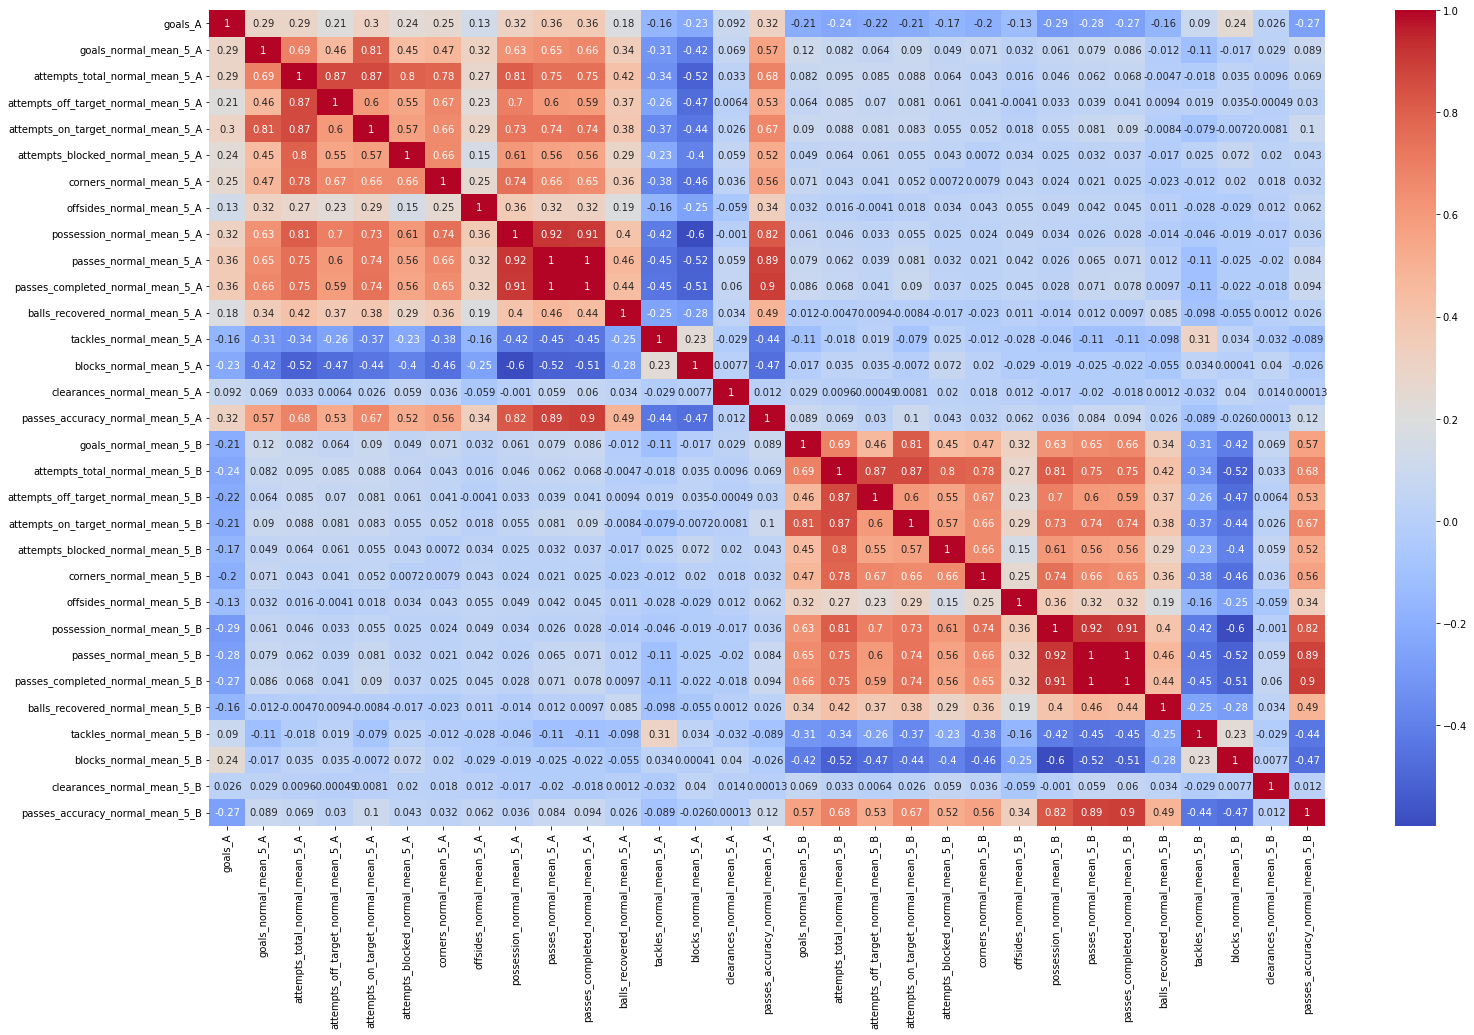

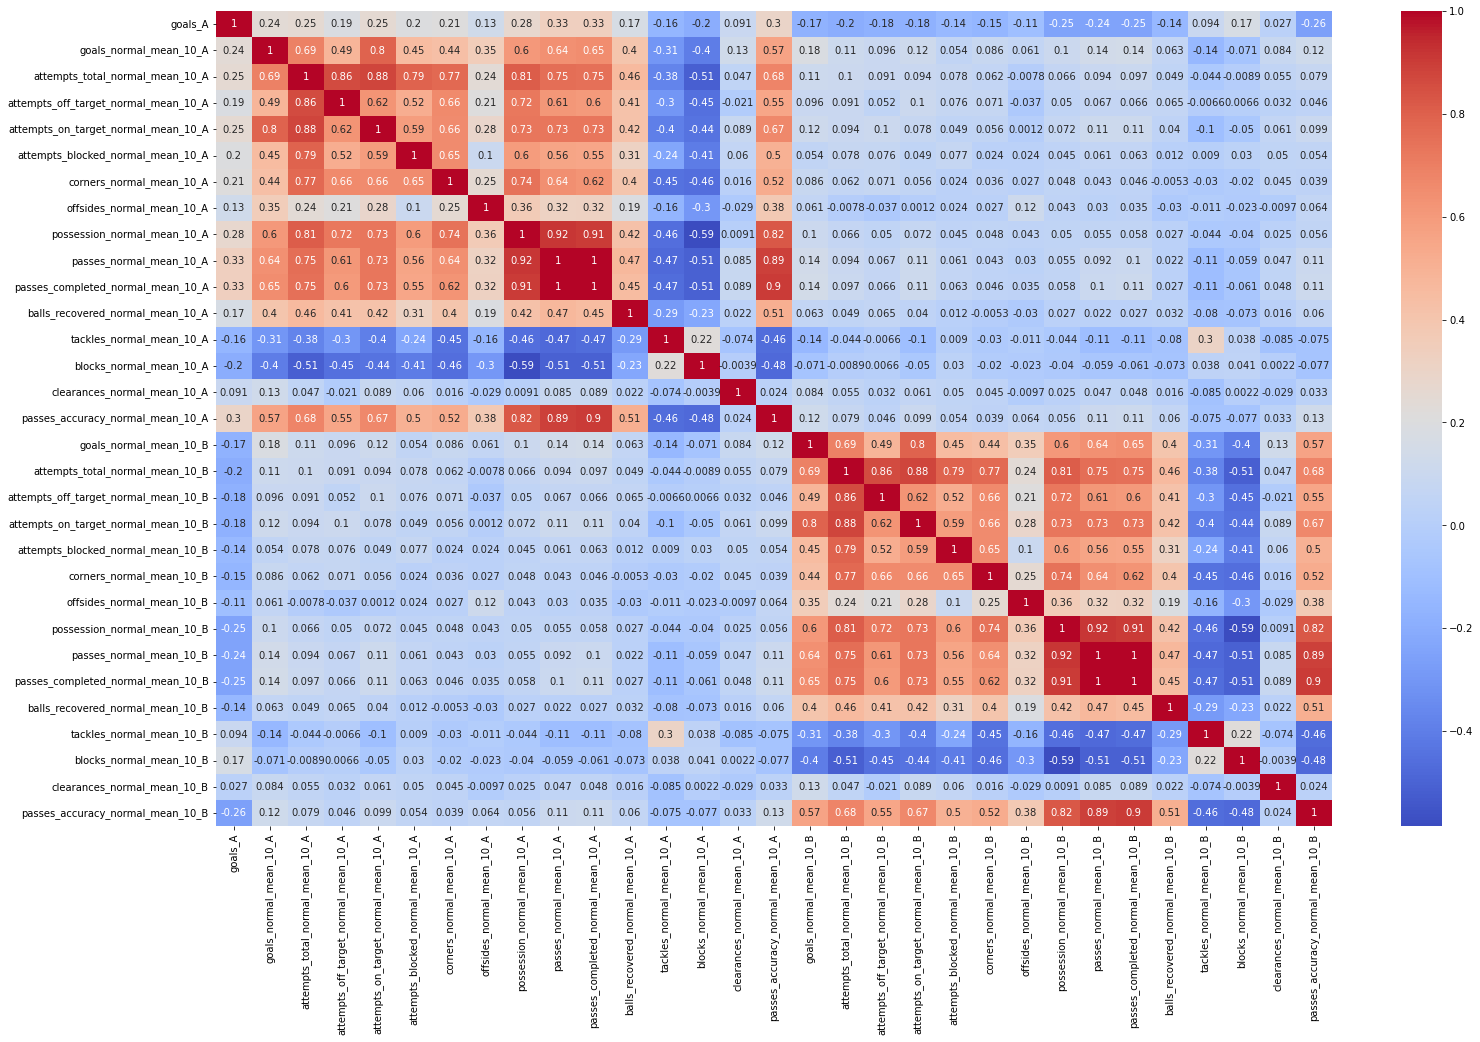

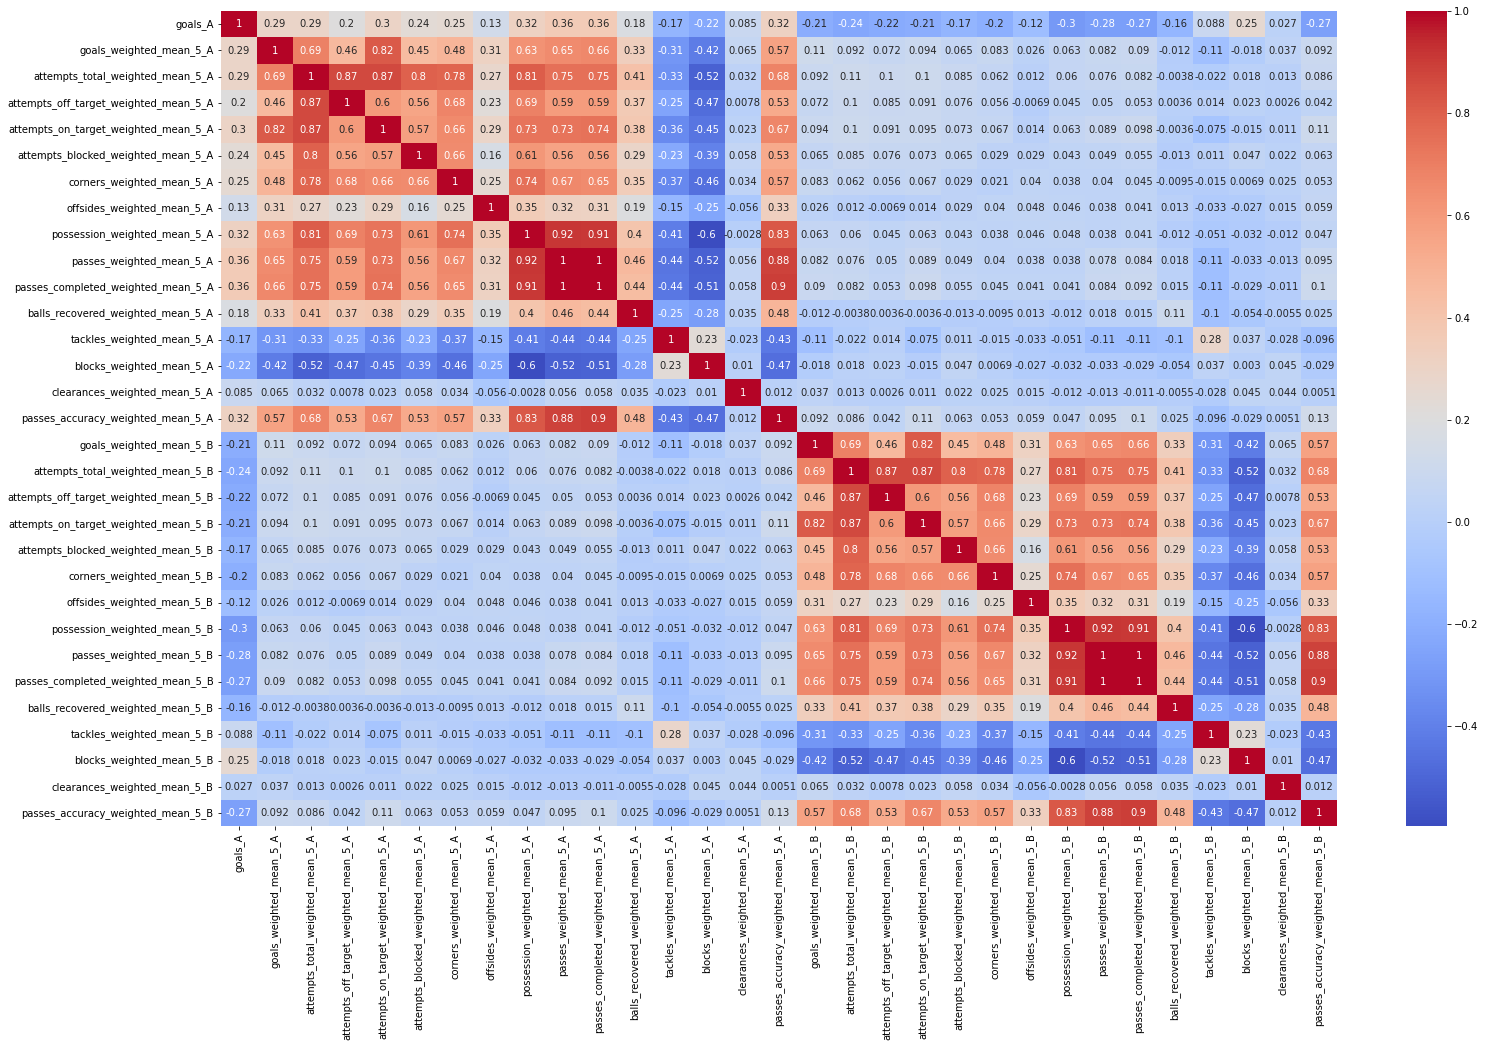

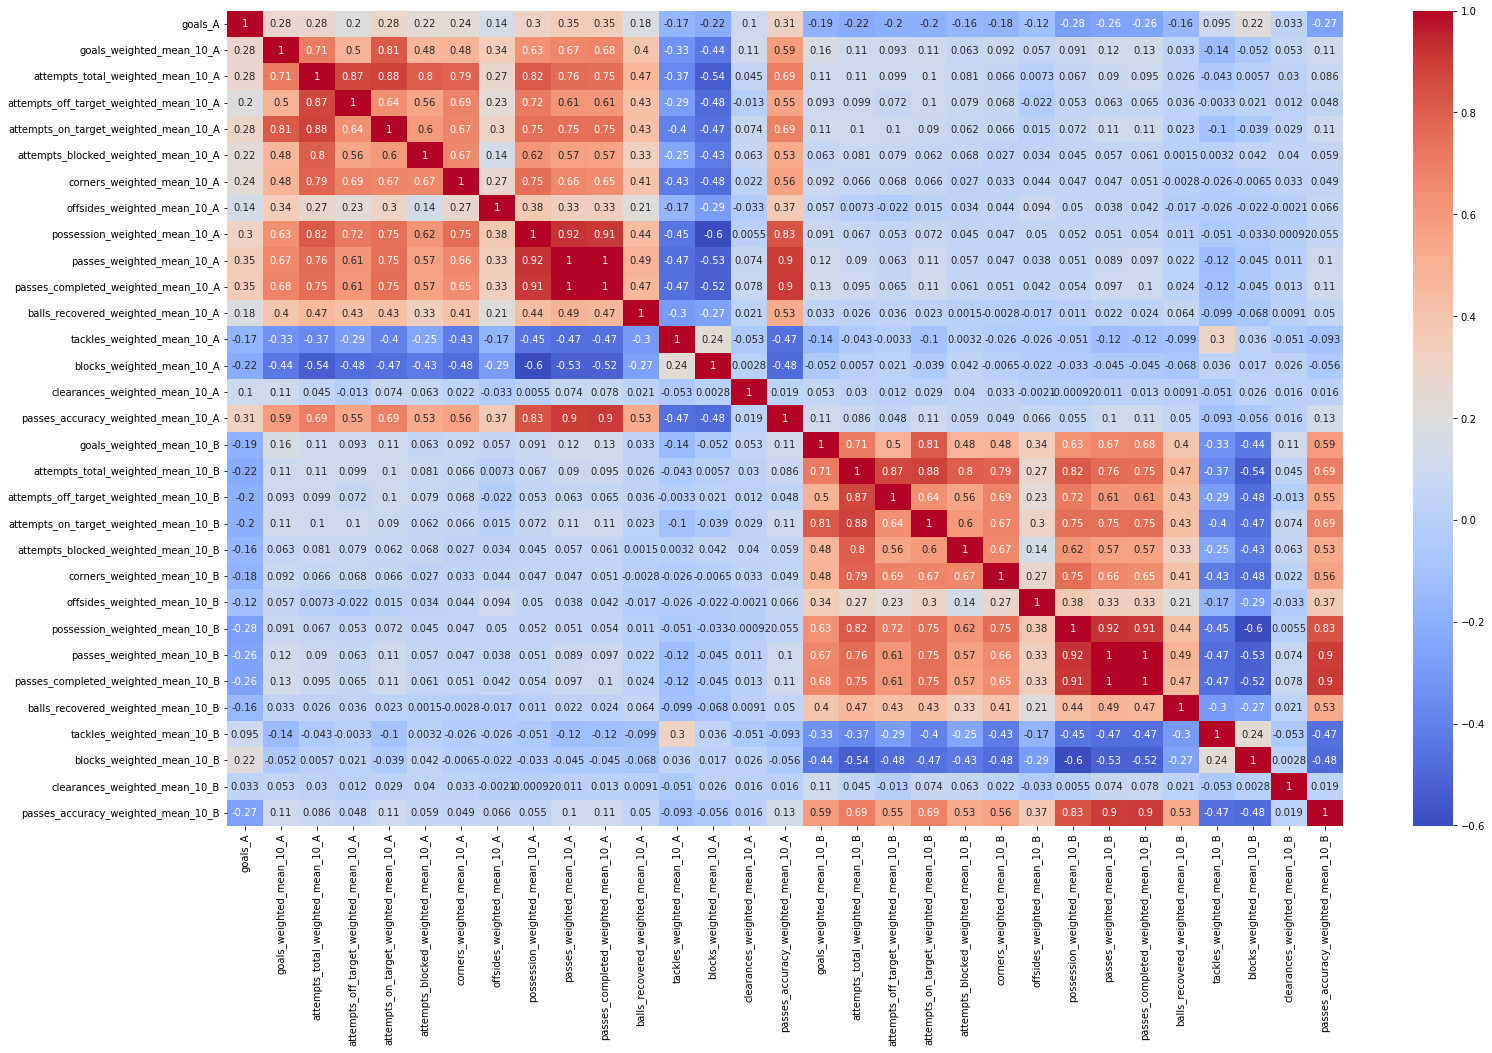

In [23]:
# We visualize the correlations between the goals scored by a team and the (weighted) means of other statistics in the 
# previous matches

for substring in ['normal_mean_5', 'normal_mean_10', 'weighted_mean_5', 'weighted_mean_10']:
    
    cols_to_keep = ['goals_A'] + [col for col in df_matches_training_feat_engi.columns if substring in col]
    
    plt.figure(figsize = (25, 15))
    sns.heatmap(df_matches_training_feat_engi[cols_to_keep].corr(), annot = True, cmap = 'coolwarm')

## Export

In [24]:
df_features_last_match.to_excel(os.path.join(path_output, output_features_last_match), index = False, encoding = 'iso-8859-1')

In [25]:
df_matches_training_feat_engi.to_excel(os.path.join(path_input, output_features_matches_training), index = False, encoding = 'iso-8859-1')